### 导包

In [3]:
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop

from keras.preprocessing.image import ImageDataGenerator

#from quiver_engine import server

import matplotlib.pyplot as plt

Using TensorFlow backend.


### 加载数据

In [20]:
# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

#constant
BATCH_SIZE = 128
NB_EPOCH = 20
NB_CLASSES = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM = RMSprop()

#load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
 
# convert to categorical
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES) 
Y_train = Y_train.reshape(X_train.shape[0],-1)
Y_test = Y_test.reshape(X_test.shape[0],-1)

# float and normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [21]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


### 搭建模型

In [5]:
# network
model = Sequential()
 
model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
__________

### 编译模型

In [6]:
model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

### 训练模型

In [7]:
#数据扩展(Data Augumenting)

#图片生成器：用以生成一个batch的图像数据，支持实时数据提升。训练时该函数会无限生成数据，直到达到规定的epoch次数为止
datagen = ImageDataGenerator(
        #使输入数据集去中心化（均值为0）, 按feature执行
        featurewise_center=False,  # set input mean to 0 over the dataset
        #使输入数据的每个样本均值为0
        samplewise_center=False,  # set each sample mean to 0
        #将输入除以数据集的标准差以完成标准化, 按feature执行
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        #将输入的每个样本除以其自身的标准差
        samplewise_std_normalization=False,  # divide each input by its std
        #对输入数据施加ZCA白化
        zca_whitening=False,  # apply ZCA whitening
        #数据提升时图片随机转动的角度
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        #图片宽度的某个比例，数据提升时图片水平偏移的幅度
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        #图片高度的某个比例，数据提升时图片竖直偏移的幅度
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #进行随机水平翻转
        horizontal_flip=True,  # randomly flip images
        #进行随机竖直翻转
        vertical_flip=False)  # randomly flip images

#匹配数据
#fit(x, augment=False, rounds=1)：计算依赖于数据的变换所需要的统计信息(均值/方差等),只有使用featurewise_center，featurewise_std_normalization或zca_whitening时需要此函数
datagen.fit(X_train)

data_augmentation = False #是否数据扩充

# train
if not data_augmentation:
    print("Not using data augmentation")
    history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE)
else:
#flow(self, X, y, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png')：
#接收numpy数组和标签为参数,生成经过数据提升或标准化后的batch数据,并在一个无限循环中不断的返回batch数据
    print("Using real-time data augmentation")
    model.fit_generator(datagen.flow(X_train, Y_train,
                           batch_size=BATCH_SIZE),
                           samples_per_epoch=X_train.shape[0],
                           nb_epoch=NB_EPOCH, 
                           verbose=VERBOSE)

#server.launch(model)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 409s 10ms/step - loss: 1.7771 - acc: 0.3622 - val_loss: 1.3885 - val_acc: 0.4949
Epoch 2/20
40000/40000 [==============================] - 393s 10ms/step - loss: 1.3434 - acc: 0.5234 - val_loss: 1.1381 - val_acc: 0.6004
Epoch 3/20
40000/40000 [==============================] - 396s 10ms/step - loss: 1.1251 - acc: 0.6011 - val_loss: 1.0052 - val_acc: 0.6501
Epoch 4/20
40000/40000 [==============================] - 398s 10ms/step - loss: 0.9811 - acc: 0.6544 - val_loss: 0.9973 - val_acc: 0.6568
Epoch 5/20
40000/40000 [==============================] - 400s 10ms/step - loss: 0.8815 - acc: 0.6907 - val_loss: 0.8666 - val_acc: 0.7024
Epoch 6/20
40000/40000 [==============================] - 396s 10ms/step - loss: 0.8053 - acc: 0.7207 - val_loss: 0.7990 - val_acc: 0.7225
Epoch 7/20
40000/40000 [==============================] - 403s 10ms/step - loss: 0.7455 - acc: 0.7411 - val_loss: 0.

### 评估模型

In [22]:
print('Testing...')
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

#save model
# model_json = model.to_json()
# open('cifar10_architecture.json', 'w').write(model_json)
# model.save_weights('cifar10_weights.h5', overwrite=True)

Testing...
10000/10000 [==============================] - 29s 3ms/step

Test score: 0.712776734543
Test accuracy: 0.7797


### 绘制模型准确率和误差曲线

dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])


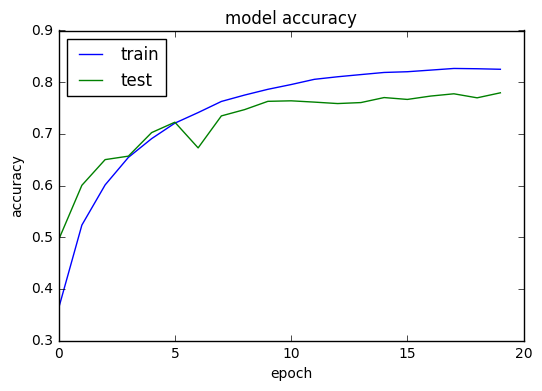

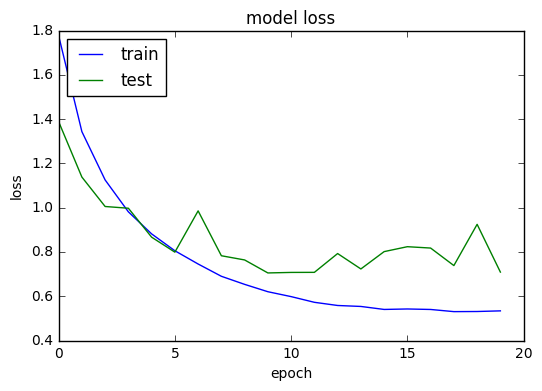

In [9]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 模型预测

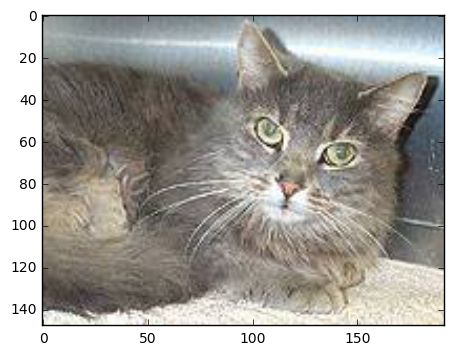

(1, 32, 32, 3)
1/1 [==============================] - 0s 7ms/step
[3]


In [11]:
import numpy as np
from skimage.transform import resize
#预测自定义图片
my_img = np.array(plt.imread('input_imgs/cat.jpg'))
plt.imshow(my_img)
plt.show()
my_img = resize(my_img,(32,32,3)) #图片缩放到指定大小28*28
my_img = my_img.reshape(1,32,32,3) #1张32*32*3的图片
print(my_img.shape)
# res = model.predict(my_img)  print(np.argmax(res))
res = model.predict_classes(my_img)
print(res)

### 保存模型

In [12]:
model.save('my_cifar10.h5')

### 测试

In [12]:
import scipy.misc
import numpy as np
from keras.models import load_model
from keras.optimizers import Adam
model = load_model('my_cifar10.h5')
#load images
img_names = ['input_imgs/cat2.jpg', 'input_imgs/dog2.jpg']
#axis(0,1,2) -> axis(1,0,2)
# imgs = [np.transpose(scipy.misc.imresize(scipy.misc.imread(img_name), (32, 32)), (1, 0, 2)).astype('float32')
#            for img_name in img_names]

imgs = [scipy.misc.imresize(scipy.misc.imread(img_name), (32, 32)).astype('float32')
           for img_name in img_names]

print(np.shape(imgs))

imgs = np.array(imgs) / 255

# train
optim = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
 
predictions = model.predict_classes(imgs)
print(predictions)

(2, 32, 32, 3)
2/2 [==============================] - 1s 368ms/step
[3 6]
